# Procesamiento de imágenes en paralelo con OpenCV

### Importar Librerias

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import cv2
from time import time

### Funciones y variables globales

In [2]:
# variable Global
N = 10; # hilos o procesos
tiempo_secuencial = 0
tiempo_paralelo_hilos = 0
tiempo_paralelo_datos = 0
tiempo_paralelo_tareas = 0
args = {
    "imagen": "gato.jpeg" # Imagen
}

In [3]:
def mostrar_imagen(titulo,imagen): # captura la imagen y lo transforma de BGR a RGB
  #imagen = cv2.cvtColor(imagen,cv2.COLOR_BGR2RGB) 
  plt.imshow(imagen)
  plt.title(titulo)
  plt.grid(False)
  plt.show

In [4]:
def dividir_imagen():
    # dividimos en ancho de la imagen
    a = w//N # retorna un número entero
    arr = []
    for i in range(N): # 0 a 3
        tl = imagen[0:h, a*i:a*(i+1)]
        arr.append(tl)
    return arr

In [5]:
def mostrar_imagen_partes(partes): # mostramos las N partes de la imagen
    for i in range(N): 
        plt.subplot(1,N,i+1)
        plt.xticks([]), plt.yticks([]) # Quita los números de los ejes
        #arr[i] = cv2.cvtColor(partes[i],cv2.COLOR_BGR2RGB)
        plt.tight_layout(pad=1) # pad es la separación entre las partes
        plt.imshow(partes[i])
    plt.show()

In [6]:
def aplicar_BN(partes): # Convierte el subconjunto a escala de grises
    ab = cv2.cvtColor(partes,cv2.COLOR_BGR2GRAY)
    return cv2.cvtColor(ab, cv2.COLOR_BGR2RGB)

In [7]:
def combinar_partes(partes):
    return np.hstack(partes)

### Visualización de la imagen

<class 'numpy.ndarray'>


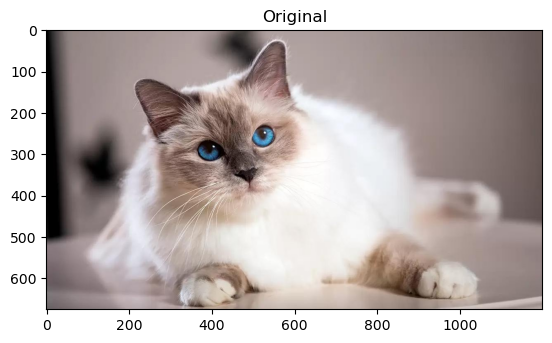

In [8]:
imagen = cv2.imread(args["imagen"]) # leemos la imagen de la variable global
imagen = cv2.cvtColor(imagen,cv2.COLOR_BGR2RGB)

mostrar_imagen("Original", imagen) # mostramos la imagen
print(type(imagen))

In [9]:
# Dimensiones de la imagen: h = alto w = ancho
(h, w) = imagen.shape[:2]

print("Altura de la imagen: %d"%(h))
print("Ancho de la imagen: %d"%(w))

Altura de la imagen: 675
Ancho de la imagen: 1200


# 1. Procesamiento Secuencial

0.021021127700805664 segundos


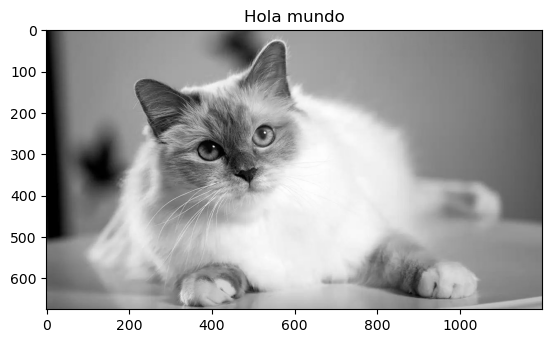

In [10]:
start = time()
imagenBNSE = aplicar_BN(imagen)
mostrar_imagen("Hola mundo",imagenBNSE)
end = time()

tiempo_secuencial = end - start
print(tiempo_secuencial, 'segundos')

# 2. Procesamiento Paralelo: Paralelismo de Tareas

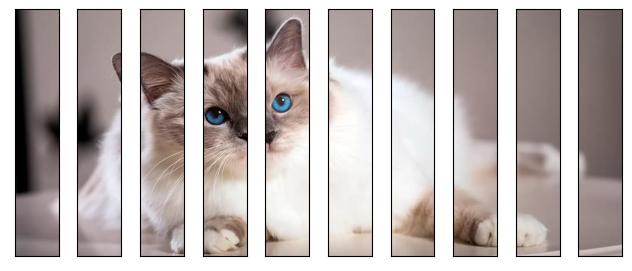

In [11]:
import multiprocessing
arr = dividir_imagen()
mostrar_imagen_partes(arr)

In [12]:
image= cv2.imread('gato.jpg')
image = cv2.cvtColor(imagen,cv2.COLOR_BGR2RGB)

height, width, channels = image.shape
div_width = width//10
half_height = height//2

arr_im=[]

    
for i in range(10):
    imm = image[:,div_width*i:div_width*(i+1)]
    arr_im.append(imm)
    cv2.imwrite("gato"+str(i)+".jpeg", arr_im[i])
    
print(len(arr_im))

for i in range(len(arr_im)):
    cv2.imshow(str(i), arr_im[i])
    
cv2.waitKey(0)


10


-1

In [13]:
def load_and_bind_images(i, img_path,result):
    img = cv2.imread(img_path)
    result[i] = img
    with lock:
        print(f"Processing image {i + 1}/{len(img_paths)}")

In [14]:
# Lista de rutas de las imágenes que deseas unir
img_paths = []
    
for i in range(8):
    img_paths.append("gato"+str(i)+".jpeg")

In [15]:
multiprocessing.cpu_count()

8

In [ ]:

start = time()

# Inicializar una lista de resultados y un objeto de bloqueo compartido
num_images = len(img_paths)
result = [None] * num_images
lock = multiprocessing.Lock()

    # Create a multiprocessing pool
pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())

    # Use the pool to load and bind the images in parallel
pool.starmap(load_and_bind_images, [(i, path,result) for i, path in enumerate(img_paths)])

    # Close the pool of processes
pool.close()
pool.join()

    # Bind (concatenate) the images into a single final image
final_image = np.concatenate(result, axis=1)  # Concatenate horizontally

    # Save the final image
cv2.imwrite("final_image.jpg", final_image)

print("Final image created successfully.")

end = time()

tiempo_paralelo_tareas = end - start

# 3. Procesamiento Paralelo: Paralelismo de Datos

In [ ]:
import cv2
import numpy as np
import multiprocessing
import time

def apply_filter(image_chunk, start_row, end_row, kernel, result, width):
    filtered_chunk = cv2.filter2D(image_chunk, -1, kernel)
    filtered_chunk_bytes = np.ndarray.tobytes(filtered_chunk)
    chunk_size = len(filtered_chunk_bytes) // width
    result[start_row * width * 1:end_row * width * 1] = filtered_chunk_bytes

def parallel_filter(image, kernel, num_processes=4):
    height, width = image.shape
    chunk_size = height // num_processes
    processes = []
    result = multiprocessing.RawArray('B', height * width * 1)  # Shared array of unsigned 8-bit integers

    for i in range(num_processes):
        start_row = i * chunk_size
        end_row = start_row + chunk_size if i < num_processes - 1 else height
        image_chunk = image[start_row:end_row]
        process = multiprocessing.Process(target=apply_filter, args=(image_chunk, start_row, end_row, kernel, result, width))
        processes.append(process)
        process.start()

    for process in processes:
        process.join()

    # Convert the shared array back to numpy array
    filtered_image = np.frombuffer(result, dtype=np.uint8)
    filtered_image = filtered_image.reshape((height, width))

    return filtered_image

start = time()


if __name__ == "__main__":
    input_image_path = "gato.jpeg"

    # Intenta cargar la imagen en escala de grises
    input_image = cv2.imread(input_image_path, cv2.IMREAD_GRAYSCALE)
    if input_image is None:
        print("Error: No se pudo cargar la imagen. Verifica la ruta del archivo.")
    else:
        # Define el kernel para convertir la imagen a escala de grises
        kernel = np.array([[0.2989, 0.5870, 0.1140]])  # Coeficientes para la conversión a escala de grises

        # Calcula el tiempo de inicio
        start_time = time.time()

        # Aplica el filtro de forma paralela
        filtered_image = parallel_filter(input_image, kernel, num_processes=4)

        # Calcula el tiempo de finalización
        end_time = time.time()

        # Guarda la imagen de salida en blanco y negro
        output_image_path = r"DatosGato.jpeg"
        cv2.imwrite(output_image_path, filtered_image)

        print(f"Procesamiento paralelo de la imagen completado. Tiempo de ejecución: {end_time - start_time} segundos. Imagen de salida en blanco y negro guardada como {output_image_path}")
        
end = time()

tiempo_paralelo_datos =end - start

# 4. Procesamiento Paralelo: Paralelismo con hilos

### Dividimos la imagen en N partes

In [49]:
arr = dividir_imagen()

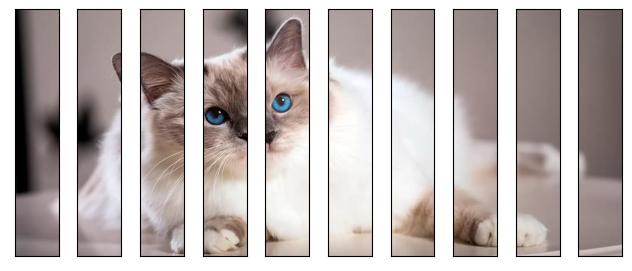

In [50]:
mostrar_imagen_partes(arr)

### Procesamiento en paralelo

In [51]:
import concurrent.futures

0.034008026123046875 segundos


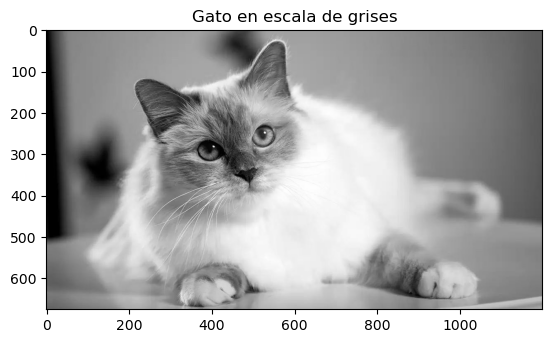

In [52]:
result = [] # partes de la imagen

inicio = time()
imagen_partes = dividir_imagen()
with concurrent.futures.ThreadPoolExecutor(max_workers=N) as executor: # N hilos
    resultados = executor.map(aplicar_BN, imagen_partes)

for resultado in resultados:
    result.append(resultado)

imagenBN = combinar_partes(result) # juntamos las partes en escala de grises
mostrar_imagen("Gato en escala de grises",imagenBN)

fin = time()
tiempo_paralelo_hilos = fin - inicio
print(tiempo_paralelo_hilos, 'segundos')

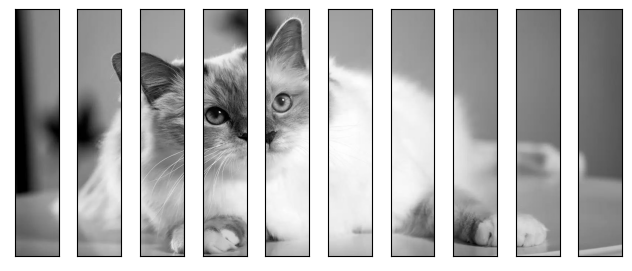

In [53]:
mostrar_imagen_partes(result)

# 5. Comparación de tiempos

In [ ]:
print("Secuencial "+tiempo_secuencial)
print("Tarea "+tiempo_paralelo_tareas)
print("Datos "+tiempo_paralelo_datos)
print("Hilos "+tiempo_paralelo_hilos)